In [9]:
!pip install opencv-python-headless
!pip install torch torchvision torchaudio
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5\yolov5


Cloning into 'yolov5'...
C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import torch
model = torch.hub.load('.', 'yolov5s', source='local') 
model.conf = 0.3  # Optional: confidence threshold

C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5\yolov5\utils\general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5  2025-8-5 Python-3.11.1 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2060 with Max-Q Design, 6144MiB)

100%|█████████████████████████████████████████████████████████████████████████████| 14.1M/14.1M [00:05<00:00, 2.51MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archiveUPDATED"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Data transforms
transform = transforms.Compose([
    transforms.Grayscale(),  # FER images are grayscale
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x48x48
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # 32x24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 64x12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128x6x6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


In [5]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import os
from collections import Counter

# ---  Focal Loss Implementation ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # prevents nans when probability is 0
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss = at * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archiveUPDATED"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")



# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class info
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load GoogLeNet with aux_logits
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
model = model.to(device)

# Class weights
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
total = sum(class_counts.values())
class_weights = [total / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Criterion: Focal Loss with class weights
criterion = FocalLoss(alpha=class_weights, gamma=2.0)

# Optimizer and scheduler
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Training config
num_epochs = 50
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs_tuple = model(images)
        outputs, aux2, aux1 = outputs_tuple  # GoogLeNet returns (main, aux2, aux1)

        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels)
        loss_aux2 = criterion(aux2, labels)

        loss = loss_main + 0.3 * loss_aux1 + 0.3 * loss_aux2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Only main output in eval mode
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100. * val_correct / val_total
    print(f"\nValidation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "UPDATEDGOOGLENETFINAL.pth")
        print("✅ Saved new best model.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Using device: cuda


Epoch 1/50: 100%|███████████████████████████████████████████████| 442/442 [08:08<00:00,  1.11s/it, acc=51.1, loss=7.69]



Validation Loss: 4.1044 | Validation Accuracy: 54.70%
✅ Saved new best model.


Epoch 2/50: 100%|███████████████████████████████████████████████| 442/442 [16:38<00:00,  2.26s/it, acc=58.4, loss=6.52]



Validation Loss: 3.9414 | Validation Accuracy: 56.80%
✅ Saved new best model.


Epoch 3/50: 100%|███████████████████████████████████████████████| 442/442 [17:12<00:00,  2.34s/it, acc=60.7, loss=5.78]



Validation Loss: 3.5011 | Validation Accuracy: 61.88%
✅ Saved new best model.


Epoch 4/50: 100%|███████████████████████████████████████████████| 442/442 [17:48<00:00,  2.42s/it, acc=62.2, loss=4.65]



Validation Loss: 3.4594 | Validation Accuracy: 61.34%
✅ Saved new best model.


Epoch 5/50: 100%|███████████████████████████████████████████████| 442/442 [18:13<00:00,  2.47s/it, acc=63.6, loss=4.83]



Validation Loss: 3.4598 | Validation Accuracy: 62.29%


Epoch 6/50: 100%|███████████████████████████████████████████████| 442/442 [17:56<00:00,  2.43s/it, acc=64.4, loss=4.74]



Validation Loss: 3.1577 | Validation Accuracy: 64.94%
✅ Saved new best model.


Epoch 7/50: 100%|███████████████████████████████████████████████| 442/442 [18:11<00:00,  2.47s/it, acc=65.6, loss=4.51]



Validation Loss: 3.2003 | Validation Accuracy: 64.07%


Epoch 8/50: 100%|███████████████████████████████████████████████| 442/442 [18:12<00:00,  2.47s/it, acc=66.3, loss=5.87]



Validation Loss: 3.1922 | Validation Accuracy: 63.92%


Epoch 9/50: 100%|█████████████████████████████████████████████████| 442/442 [18:00<00:00,  2.44s/it, acc=67, loss=4.88]



Validation Loss: 3.0814 | Validation Accuracy: 65.36%
✅ Saved new best model.


Epoch 10/50: 100%|██████████████████████████████████████████████| 442/442 [18:05<00:00,  2.46s/it, acc=67.5, loss=3.35]



Validation Loss: 3.1431 | Validation Accuracy: 65.35%


Epoch 11/50: 100%|██████████████████████████████████████████████| 442/442 [18:11<00:00,  2.47s/it, acc=67.8, loss=4.28]



Validation Loss: 3.1194 | Validation Accuracy: 66.59%


Epoch 12/50: 100%|██████████████████████████████████████████████| 442/442 [18:50<00:00,  2.56s/it, acc=69.4, loss=3.96]



Validation Loss: 3.2155 | Validation Accuracy: 66.61%


Epoch 13/50: 100%|██████████████████████████████████████████████| 442/442 [19:08<00:00,  2.60s/it, acc=69.3, loss=4.54]



Validation Loss: 3.0548 | Validation Accuracy: 65.66%
✅ Saved new best model.


Epoch 14/50: 100%|██████████████████████████████████████████████| 442/442 [19:17<00:00,  2.62s/it, acc=70.4, loss=4.24]



Validation Loss: 3.1234 | Validation Accuracy: 66.89%


Epoch 15/50: 100%|███████████████████████████████████████████████| 442/442 [19:22<00:00,  2.63s/it, acc=71.3, loss=3.2]



Validation Loss: 3.1418 | Validation Accuracy: 66.45%


Epoch 16/50: 100%|██████████████████████████████████████████████| 442/442 [19:02<00:00,  2.58s/it, acc=71.9, loss=4.08]



Validation Loss: 3.1605 | Validation Accuracy: 67.17%


Epoch 17/50: 100%|██████████████████████████████████████████████| 442/442 [18:36<00:00,  2.53s/it, acc=72.7, loss=4.93]



Validation Loss: 3.0817 | Validation Accuracy: 67.91%


Epoch 18/50: 100%|██████████████████████████████████████████████| 442/442 [18:25<00:00,  2.50s/it, acc=77.2, loss=3.68]



Validation Loss: 3.0509 | Validation Accuracy: 69.83%
✅ Saved new best model.


Epoch 19/50: 100%|███████████████████████████████████████████████| 442/442 [19:11<00:00,  2.61s/it, acc=78.7, loss=3.2]



Validation Loss: 3.0501 | Validation Accuracy: 69.63%
✅ Saved new best model.


Epoch 20/50: 100%|██████████████████████████████████████████████| 442/442 [18:30<00:00,  2.51s/it, acc=79.6, loss=2.88]



Validation Loss: 3.1920 | Validation Accuracy: 69.34%


Epoch 21/50: 100%|██████████████████████████████████████████████| 442/442 [18:16<00:00,  2.48s/it, acc=80.7, loss=2.11]



Validation Loss: 3.3369 | Validation Accuracy: 69.56%


Epoch 22/50: 100%|███████████████████████████████████████████████| 442/442 [18:01<00:00,  2.45s/it, acc=80.6, loss=1.9]



Validation Loss: 3.2709 | Validation Accuracy: 70.36%


Epoch 23/50: 100%|██████████████████████████████████████████████| 442/442 [17:29<00:00,  2.38s/it, acc=81.9, loss=2.89]



Validation Loss: 3.4503 | Validation Accuracy: 69.52%


Epoch 24/50: 100%|██████████████████████████████████████████████| 442/442 [17:11<00:00,  2.33s/it, acc=83.5, loss=2.31]



Validation Loss: 3.6050 | Validation Accuracy: 69.92%


Epoch 25/50: 100%|██████████████████████████████████████████████| 442/442 [17:20<00:00,  2.35s/it, acc=84.1, loss=1.66]



Validation Loss: 3.6351 | Validation Accuracy: 69.90%


Epoch 26/50: 100%|██████████████████████████████████████████████| 442/442 [17:21<00:00,  2.36s/it, acc=84.4, loss=1.73]



Validation Loss: 3.6540 | Validation Accuracy: 70.17%


Epoch 27/50: 100%|██████████████████████████████████████████████| 442/442 [17:29<00:00,  2.37s/it, acc=84.4, loss=1.52]



Validation Loss: 3.7186 | Validation Accuracy: 69.86%


Epoch 28/50: 100%|██████████████████████████████████████████████| 442/442 [17:40<00:00,  2.40s/it, acc=84.9, loss=1.58]



Validation Loss: 3.7057 | Validation Accuracy: 70.04%


Epoch 29/50: 100%|████████████████████████████████████████████████| 442/442 [17:39<00:00,  2.40s/it, acc=85, loss=1.96]



Validation Loss: 3.7978 | Validation Accuracy: 70.04%
⏹️ Early stopping triggered.


In [7]:
from torchvision import models
import torch.nn as nn

# Class info
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Recreate the model architecture
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Load the saved weights
model.load_state_dict(torch.load("UPDATEDGOOGLENETFINAL.pth", map_location=device))

# Set to evaluation mode
model.eval()
model.to(device)

Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Using device: cuda


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
correct = 0
total = 0
test_loss = 0.0
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                class_correct[label] += 1
            class_total[label] += 1

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

print(f"\nTest Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Per-class accuracy breakdown
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(classes):
    if class_total[i] == 0:
        print(f"{class_name}: No samples")
    else:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"{class_name}: {acc:.2f}%")


IndexError: index 1 is out of bounds for dimension 1 with size 1

# YOLOv11

In [1]:
!pip install ultralytics opencv-python-headless

from ultralytics import YOLO

# Load YOLOv11 small model
model = YOLO('yolo11s.pt')

model.conf = 0.3 # Confidence threshold (used during predict)


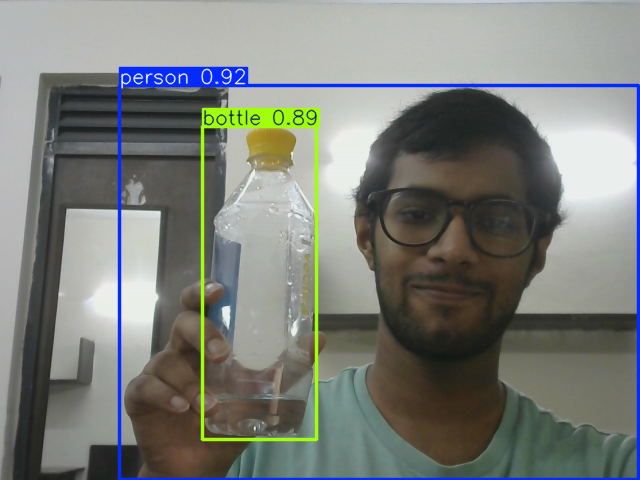

In [5]:
import warnings
warnings.filterwarnings('ignore')

import cv2
from IPython.display import display, clear_output
from PIL import Image
from ultralytics import YOLO

# Load YOLOv11 model
model = YOLO('yolo11s.pt')

# Open webcam (0 = default camera)
cap = cv2.VideoCapture(0)

frame_count = 0  # Limit frame count for testing in Jupyter

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Run detection
    results = model(frame)

    # Plot (annotate) results on the frame
    annotated_frame = results[0].plot()

    # Convert to RGB and show in Jupyter
    rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(rgb_frame)
    clear_output(wait=True)
    display(img)

    # Stop after 150 frames
    frame_count += 1
    if frame_count >= 150:
        break

# Release webcam
cap.release()


In [6]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


In [7]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set paths
data_dir = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\archiveUPDATED"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Data transforms
transform = transforms.Compose([
    transforms.Grayscale(),  # FER images are grayscale
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x48x48
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  # 32x24x24

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 64x12x12

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # 128x6x6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [9]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


In [14]:
import warnings
warnings.filterwarnings('ignore')

from torchvision import models
import torch.nn as nn

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes=len(classes)

'''
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)  # prevents nans when probability is 0
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            at = self.alpha.gather(0, targets)
            focal_loss = at * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Class weights
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
total = sum(class_counts.values())
class_weights = [total / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# Loss and optimizer
criterion = FocalLoss(alpha=class_weights, gamma=2.0)
optimizer = Adam(model.parameters(), lr=0.001)
'''

# Recreate the model architecture
model = models.googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

# Load the saved weights
model_path = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5\UPDATEDGOOGLENETFINAL.pth"
model.load_state_dict(torch.load(model_path, map_location=device))


# Set to evaluation mode
model.eval()
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
import cv2
import torch
import numpy as np
from PIL import Image
from collections import deque, Counter
from torchvision import transforms
import warnings
from ultralytics import YOLO

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv11s model (Ultralytics)
yolo_model = YOLO("yolo11s.pt")
yolo_model.to(device)

# Load the GoogLeNet emotion model and classes
model_path = r"C:\Users\Prani\Desktop\My Files\Pranit\Uni Files\SEM VI\Minor - 2\IBM INTERNSHIP\yolov5\UPDATEDGOOGLENETFINAL.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)
emotion_model = model
emotion_model.eval()

emotion_labels = classes  # e.g. ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Image transform for emotion model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Buffer for smoothing predictions
prediction_buffer = deque(maxlen=30)

# --- Webcam Capture ---
cap = cv2.VideoCapture(0)
print("🟢 Starting real-time emotion detection...")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # YOLOv11s detection
    results = yolo_model(frame)
    boxes = results[0].boxes  # First image/frame in the batch

    if boxes is not None:
        for box in boxes:
            cls = int(box.cls.cpu().item())
            if cls == 0:  # Class 0 is person in COCO
                xyxy = box.xyxy.cpu().numpy().astype(int)[0]
                x1, y1, x2, y2 = xyxy

                # Crop face region from detected person box
                face = frame[y1:y2, x1:x2]
                try:
                    face_pil = Image.fromarray(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
                    face_tensor = transform(face_pil).unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = emotion_model(face_tensor)
                        if isinstance(output, tuple):
                            output = output[0]
                        pred = torch.argmax(output, dim=1).item()
                        pred_label = emotion_labels[pred]

                    # Append prediction to buffer for smoothing
                    prediction_buffer.append(pred_label)

                    # Get most common prediction in buffer
                    smoothed_prediction = Counter(prediction_buffer).most_common(1)[0][0]

                    # Draw bounding box + label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, smoothed_prediction.upper(), (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                except Exception as e:
                    print("Skipping face:", e)
                break  # Remove this break if you want to process all persons

    # Show annotated frame
    cv2.imshow("Real-Time Emotion Detection", frame)

    # Exit loop on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
print("🛑 Stopped.")


🟢 Starting real-time emotion detection...

0: 480x640 1 person, 20.0ms
Speed: 1.8ms preprocess, 20.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.5ms
Speed: 8.6ms preprocess, 112.5ms inference, 12.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 112.7ms
Speed: 8.8ms preprocess, 112.7ms inference, 12.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 96.9ms
Speed: 6.8ms preprocess, 96.9ms inference, 12.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 99.5ms
Speed: 7.4ms preprocess, 99.5ms inference, 11.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 103.2ms
Speed: 7.5ms preprocess, 103.2ms inference, 11.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 104.7ms
Speed: 6.9ms preprocess, 104.7ms inference, 13.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 119.5ms
Speed: 7.0ms preprocess, 119.5ms